In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
data = pd.read_excel("Realized Schedule 20210101-20220228.xlsx",engine='openpyxl')
sns.set_theme()
data

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor
0,2021-01-01 06:35:00,IA,874,DEN,73W,J,US,142,0.408451
1,2021-01-01 10:35:00,JZ,818,YHM,AT7,J,CA,74,0.189189
2,2021-01-01 12:05:00,IA,876,DEN,73W,J,US,142,0.570423
3,2021-01-01 13:20:00,CN,514,EST,AT7,J,US,72,0.333333
4,2021-01-01 14:20:00,LJ,3140,DEN,32A,J,US,186,0.204301
...,...,...,...,...,...,...,...,...,...
39444,2022-02-28 18:45:00,VW,986,YYZ,319,J,CA,144,0.847222
39445,2022-02-28 19:25:00,LJ,667,YDQ,319,J,CA,156,0.871795
39446,2022-02-28 20:00:00,VW,3406,MYV,E90,J,US,98,0.857143
39447,2022-02-28 19:30:00,LJ,663,RUT,32N,J,US,186,0.682796


## Encode dates

In [2]:
# holidays 
from pandas.tseries.holiday import *
from pandas.tseries.offsets import CustomBusinessDay

class GothamBusinessCalendar(AbstractHolidayCalendar):
   rules = [
     Holiday('New Year', month=1, day=1, observance=sunday_to_monday),
     Holiday('Groundhog Day', month=1, day=6, observance=sunday_to_monday),
     Holiday('St. Patricks Day', month=3, day=17, observance=sunday_to_monday),
     Holiday('April Fools Day', month=4, day=1),
     Holiday('Good Friday', month=1, day=1, offset=[Easter(), Day(-2)]),
     Holiday('Labor Day', month=5, day=1, observance=sunday_to_monday),
     Holiday('Canada Day', month=7, day=1, observance=sunday_to_monday),
     Holiday('July 4th', month=7, day=4, observance=nearest_workday),
     Holiday('All Saints Day', month=11, day=1, observance=sunday_to_monday),
     Holiday('Christmas', month=12, day=25, observance=nearest_workday)
   ]

Gotham_BD = CustomBusinessDay(calendar=GothamBusinessCalendar())

# add time stuff
data["Hour"] = data.ScheduleTime.dt.hour
data["Date"] = data.ScheduleTime.dt.date
data["Holiday"] = data.Date.isin(pd.date_range(min(data.Date), end=max(data.Date), freq=Gotham_BD)) == False
data["Weekday"] = data.ScheduleTime.dt.day_name()

data["QuarterEnd"] = data.ScheduleTime.dt.to_period("Q").dt.end_time
data["MonthEnd"] = data.ScheduleTime.dt.to_period("M").dt.end_time
# data["BusinessMonthEnd"] = data.ScheduleTime.dt.to_period("BM").dt.end_time
data["TimeToQuarterEnd"] = (data["QuarterEnd"] - data["ScheduleTime"]).dt.days
data["TimeToMonthEnd"] = (data["MonthEnd"] - data["ScheduleTime"]).dt.days



## Encode time of day as cos and sin
seconds_from_midnight = ((data.ScheduleTime - data.ScheduleTime.dt.normalize()) / pd.Timedelta('1 second')).astype(int)
radians= 2*np.pi*seconds_from_midnight/(3600*24)
data["TimeCos"] = radians.apply(np.cos)
data["TimeSin"] = radians.apply(np.sin)

## Encode day of month as cos + sin
fraction_of_month = (data.ScheduleTime.dt.day-1) / (data.MonthEnd.dt.day-1)
radians=2*np.pi*fraction_of_month
data["DayCos"] = radians.apply(np.cos)
data["DaySin"] = radians.apply(np.sin)

## Encode month as cos + sin
fraction_of_year = (data.ScheduleTime.dt.month-1) / 11
radians=2*np.pi*fraction_of_year
data["MonthCos"] = radians.apply(np.cos)
data["MonthSin"] = radians.apply(np.sin)


lt = (data.ScheduleTime - data.ScheduleTime.min()).dt.total_seconds()
lt = (lt - lt.mean())/lt.std()
data["LinearTime"] = lt

## Encode data as cos + sin


# data["TimeToBusinessMonthEnd"] = (data["BusinessMonthEnd"] - data["ScheduleTime"]).dt.days

## Flight numbers are not unique across airlines and destinations
They should be unique across airlines and possibly destinations. New flight numbers are combination of airline code + flight number

In [3]:
data["FlightNumber2"] = data.Airline+data.FlightNumber.astype("str")

In [4]:
d_ = data[["Airline","Destination","FlightNumber2"]]
query = d_.groupby("FlightNumber2").agg({"Airline": "nunique","Destination":"nunique"})
query[query.Airline!=1]


,Airline,Destination
FlightNumber2,,


These new flight numbers are unique across airlines

In [6]:
cols = list(data.columns)
print(cols)
cols.remove("FlightNumber")
data[cols].to_csv("processed_data.csv",index=False)

['ScheduleTime', 'Airline', 'FlightNumber', 'Destination', 'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor', 'Hour', 'Date', 'Holiday', 'Weekday', 'QuarterEnd', 'MonthEnd', 'TimeToQuarterEnd', 'TimeToMonthEnd', 'TimeCos', 'TimeSin', 'DayCos', 'DaySin', 'MonthCos', 'MonthSin', 'LinearTime', 'FlightNumber2']


## Target variable: Load Factor

Some flights have load factors > 1

In [14]:
y = data.LoadFactor
y.describe()

count    39449.000000
mean         0.537443
std          0.273094
min          0.000000
25%          0.311111
50%          0.541667
75%          0.777778
max          1.475177
Name: LoadFactor, dtype: float64

In [ ]:
sns.histplot(y)

In [15]:
data[data.LoadFactor>1]

,ScheduleTime,Airline,FlightNumber,Destination,AircraftType,FlightType,Sector,SeatCapacity,LoadFactor,Hour,...,TimeToQuarterEnd,TimeToMonthEnd,TimeCos,TimeSin,DayCos,DaySin,MonthCos,MonthSin,LinearTime,FlightNumber2
764,2021-01-28 16:45:00,CN,515,EST,AT7,J,US,72,1.013889,16,...,62,3,-0.321439,-0.946930,0.809017,-0.587785,1.000000,0.000000,-2.454955,CN515
1056,2021-02-13 11:35:00,CN,512,EST,AT7,J,US,72,1.013889,11,...,46,15,-0.994056,0.108867,-0.939693,0.342020,0.841254,0.540641,-2.294506,CN512
1096,2021-02-15 11:00:00,CN,513,EST,AT4,J,US,46,1.043478,11,...,44,13,-0.965926,0.258819,-0.993238,-0.116093,0.841254,0.540641,-2.274424,CN513
1443,2021-03-05 16:40:00,CN,556,CKE,AT4,J,US,46,1.021739,16,...,26,26,-0.342020,-0.939693,0.669131,0.743145,0.415415,0.909632,-2.089057,CN556
1488,2021-03-07 18:35:00,OF,575,OTH,32Q,J,US,160,1.006250,18,...,24,24,0.152123,-0.988362,0.309017,0.951057,0.415415,0.909632,-2.067916,OF575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38402,2022-02-26 18:30:00,FZ,609,AMN,73H,C,US,186,1.021505,18,...,33,2,0.130526,-0.991445,0.893633,-0.448799,0.841254,0.540641,1.550716,FZ609
38784,2022-02-13 09:55:00,ZD,742,YAD,73H,J,CA,189,1.021164,9,...,46,15,-0.854912,0.518773,-0.939693,0.342020,0.841254,0.540641,1.414939,ZD742
38799,2022-02-13 15:00:00,LJ,769,YEG,320,J,CA,186,1.016129,15,...,46,15,-0.707107,-0.707107,-0.939693,0.342020,0.841254,0.540641,1.417092,LJ769
39311,2022-02-26 08:55:00,ZD,742,YAD,73H,J,CA,189,1.015873,8,...,33,2,-0.691513,0.722364,0.893633,-0.448799,0.841254,0.540641,1.546658,ZD742


Text(0.5, 1.0, 'Flights to each country')

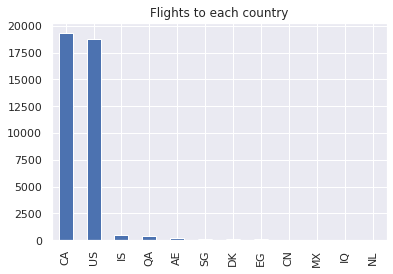

In [7]:
ax = data.Sector.value_counts().plot.bar()
ax.set_title("Flights to each country")

/home/hinge/.venv/MRI-to-PET/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


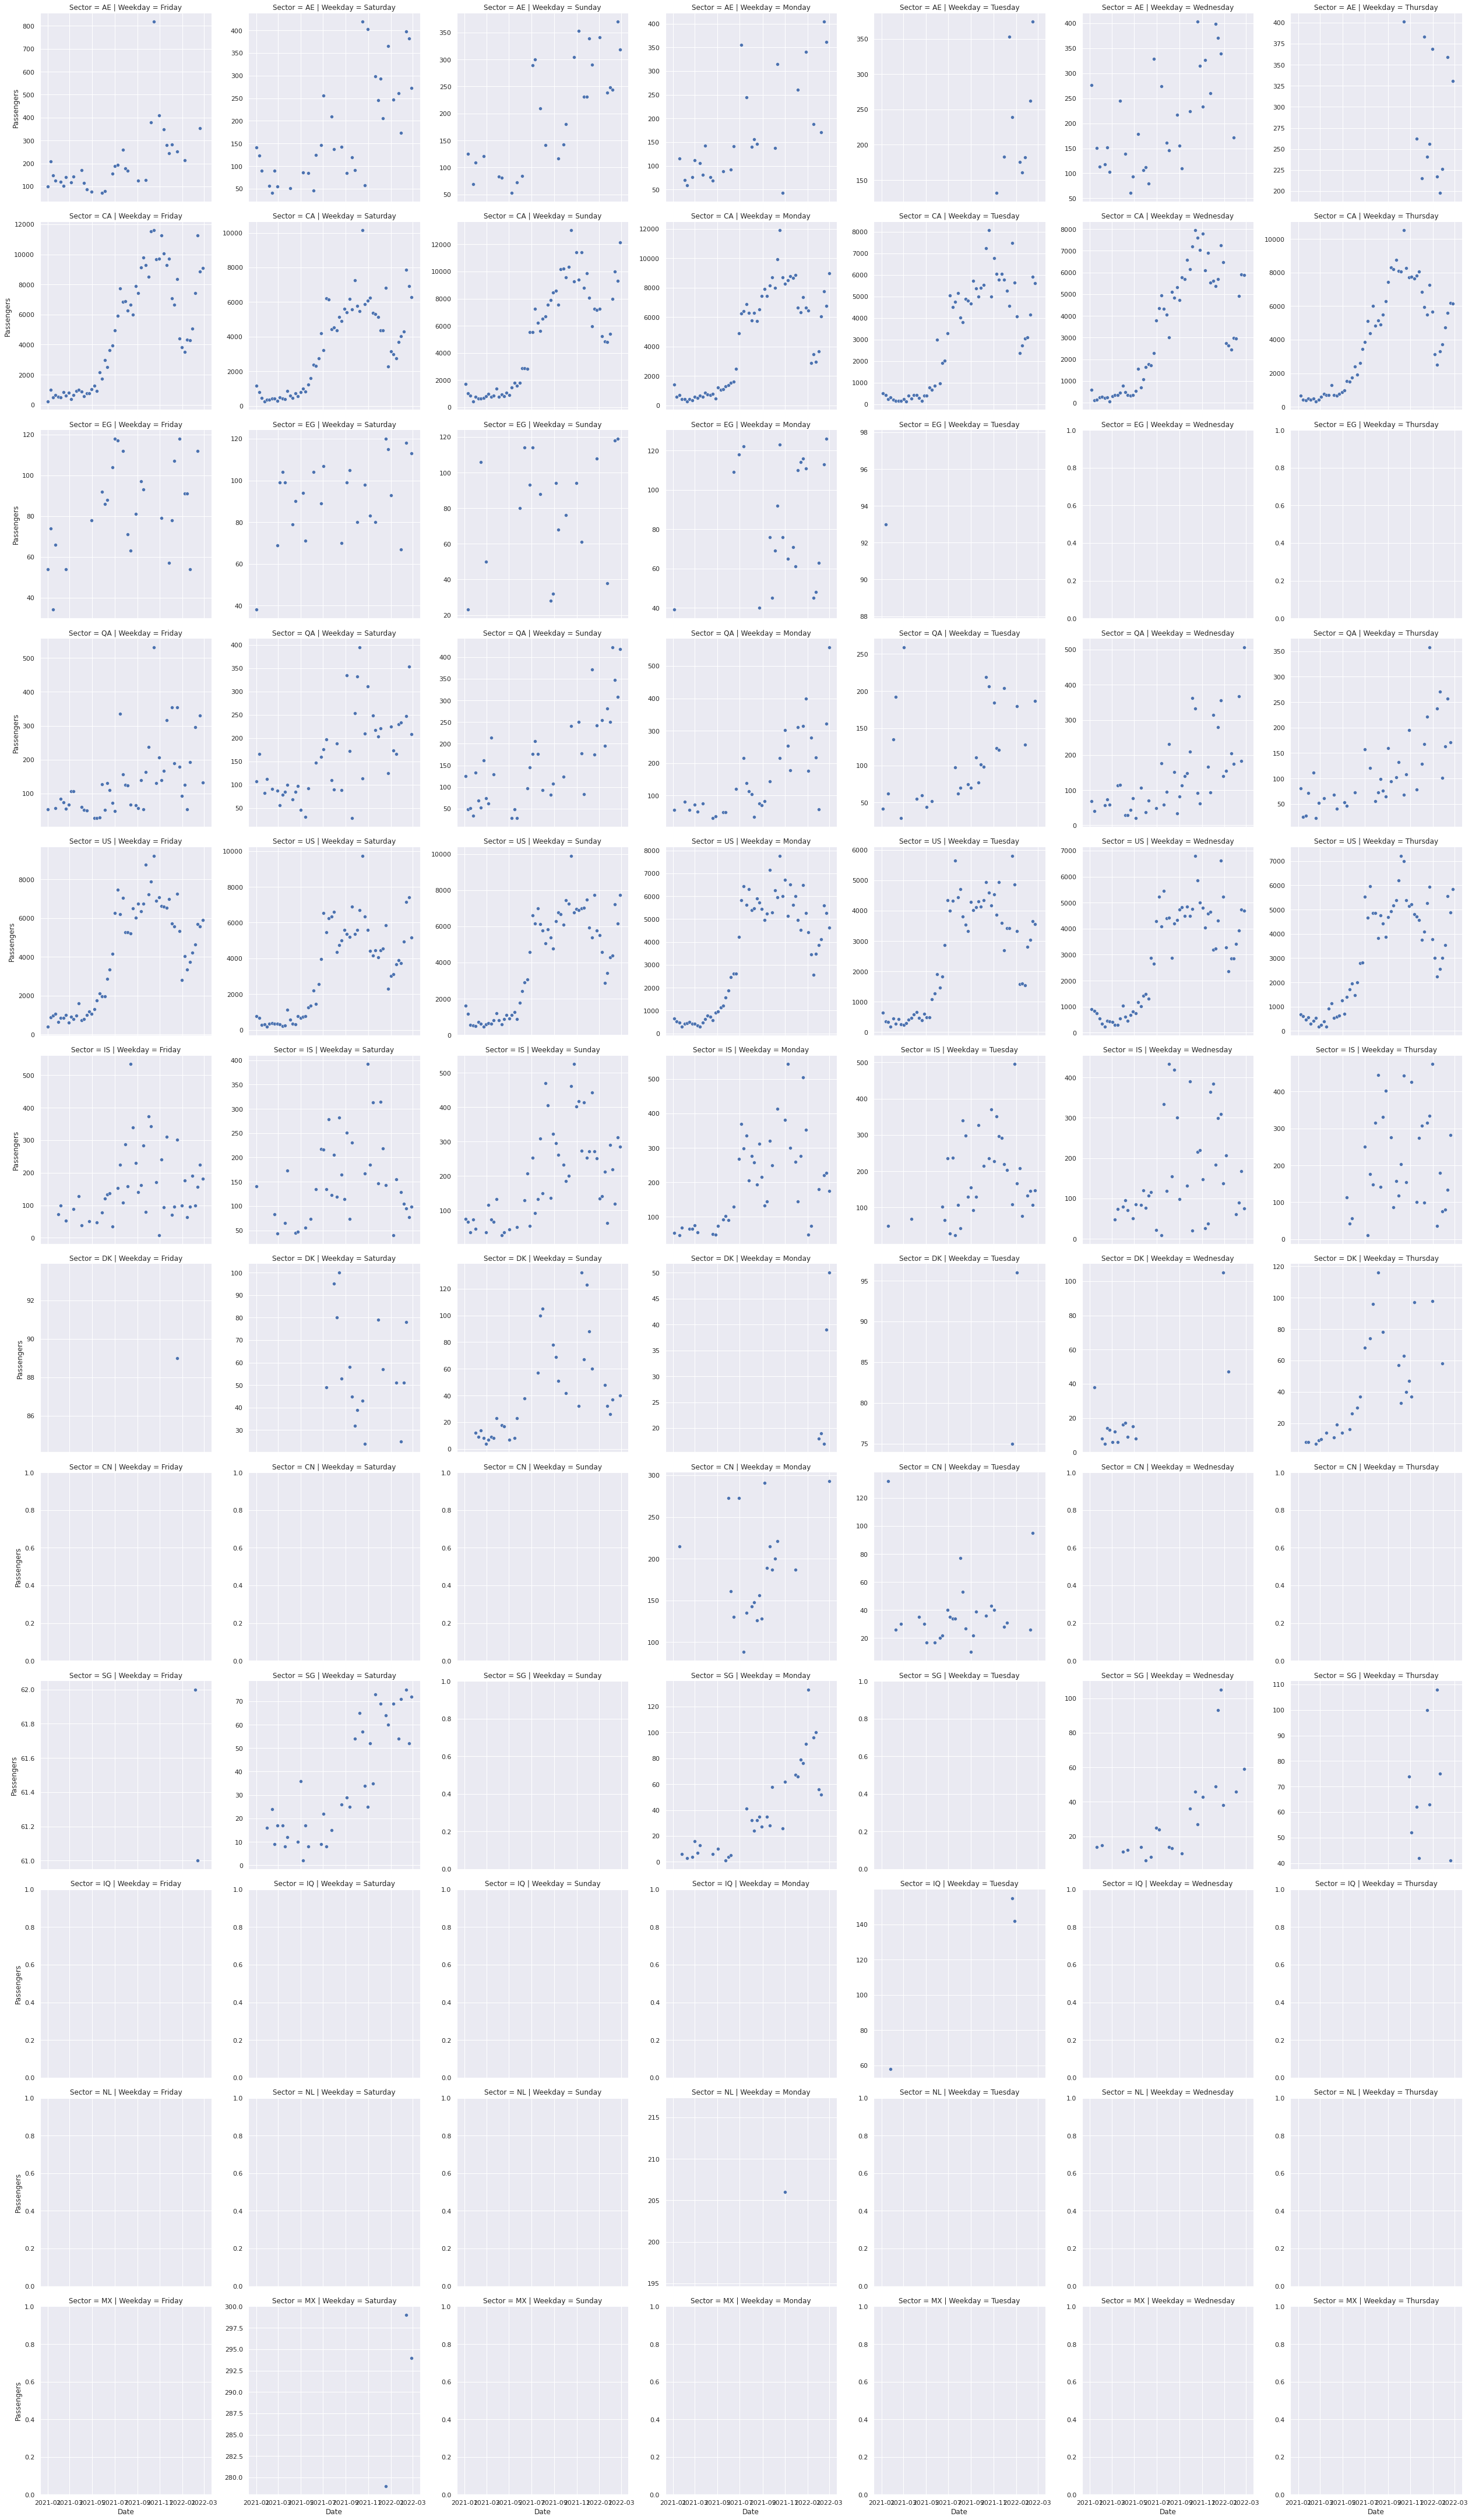

In [7]:
data["Passengers"] = data.SeatCapacity*data.LoadFactor
d2 = data.groupby(["Date","Sector","Weekday"]).sum().reset_index()

#d3 = d2[d2.Sector.isin(["US","CA"])]
#d4 = d2[~d2.Sector.isin(["US","CA"])]

import seaborn as sns
sns.relplot("Date","Passengers",data=d2,row="Sector",kind="scatter",col="Weekday",facet_kws={'sharey': False, 'sharex': True})

In [ ]:
data.

/home/hinge/.virtualenvs/ai/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


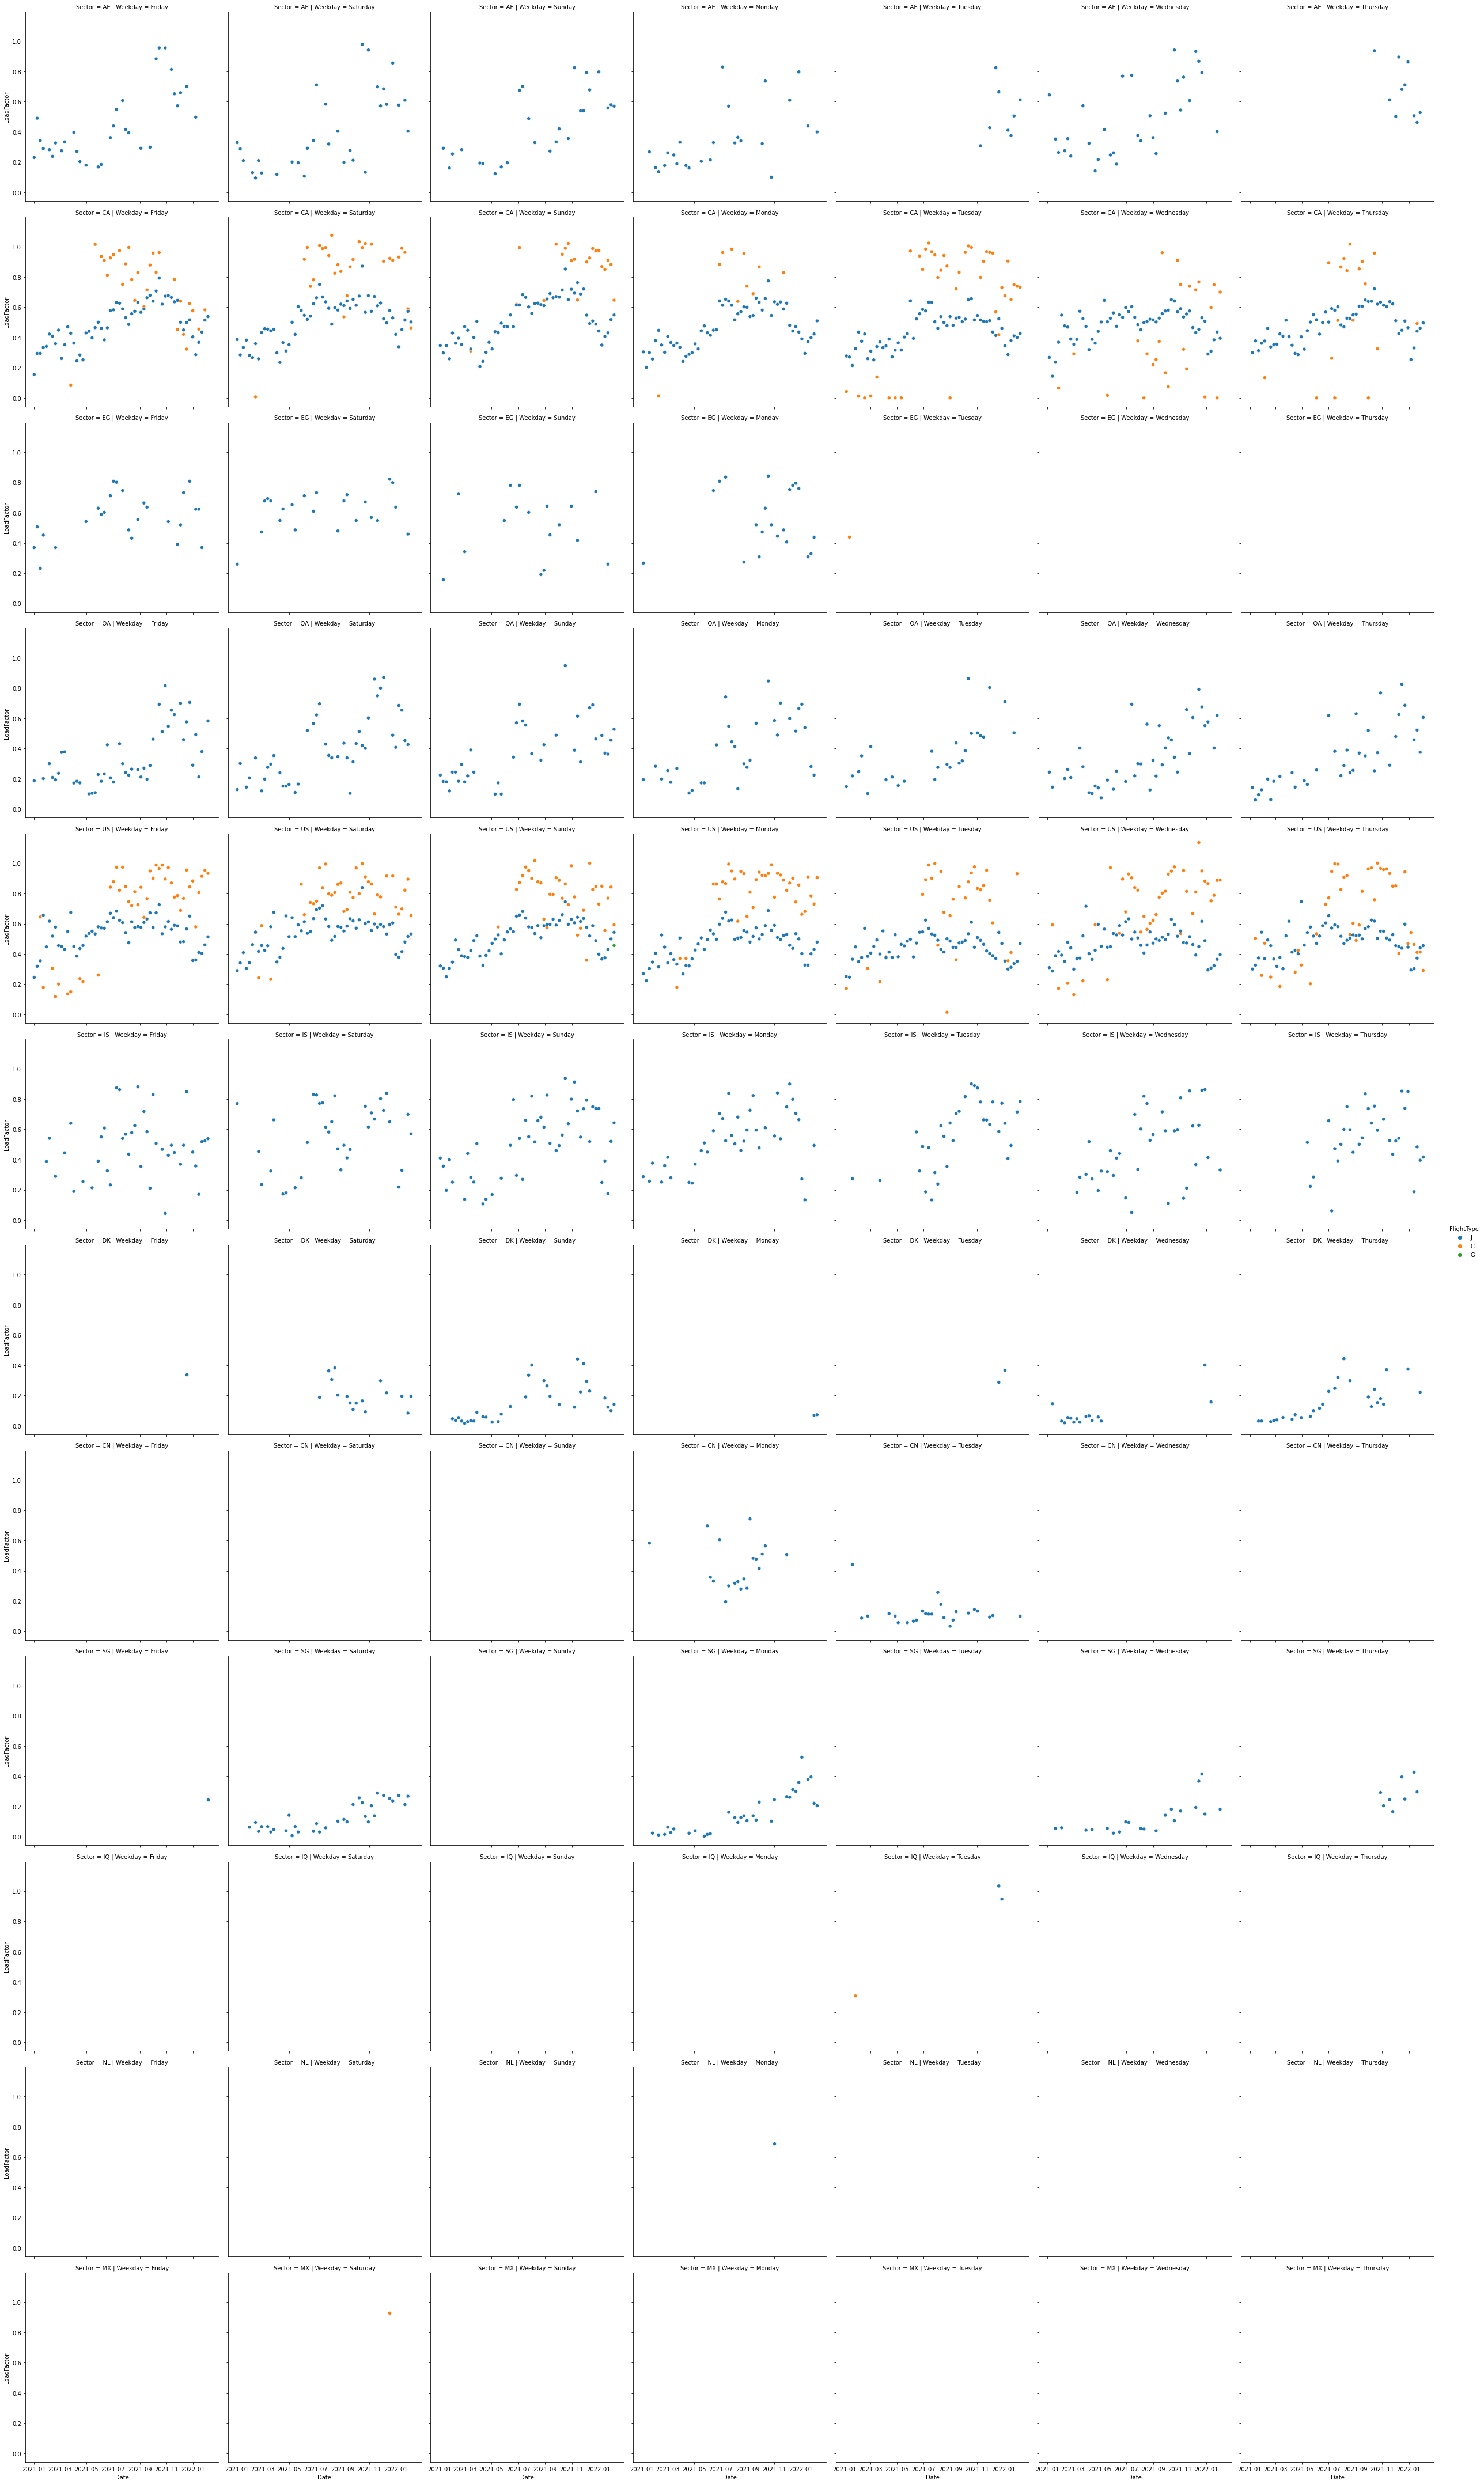

In [106]:
d_ = data.groupby(["Date","Sector","Weekday","FlightType"]).mean().reset_index()
sns.relplot("Date","LoadFactor",data=d_,row="Sector",kind="scatter",col="Weekday",hue="FlightType")

<AxesSubplot:>

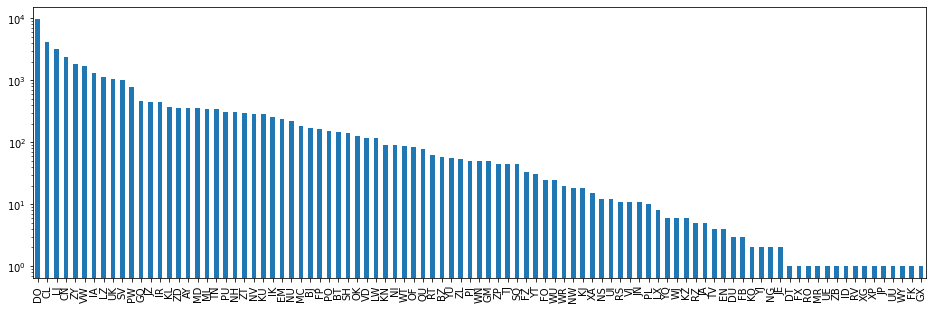

In [97]:
from matplotlib import pyplot as plt
counts = d.Airline.value_counts()
plt.figure(figsize=(16,5))
counts.plot.bar(logy=True)

In [118]:
fig

NameError: name 'fig' is not defined

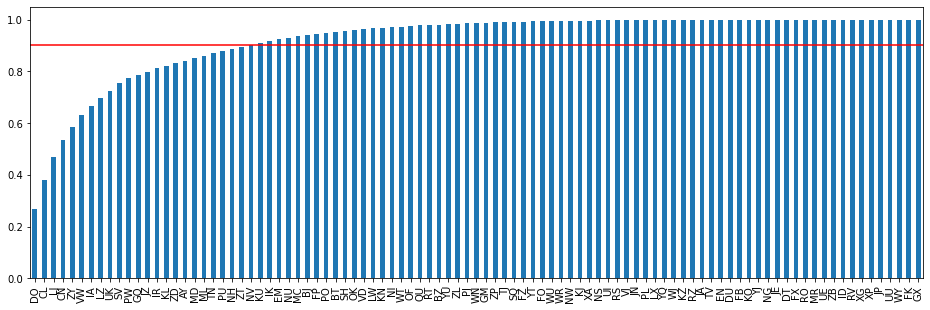

In [129]:
plt.figure(figsize=(16,5))
ax = (counts/counts.sum()).cumsum().plot.bar()
plt.plot(ax.get_xlim(),[0.9,0.9],'r')


In [100]:
valid_airlines = counts.index[counts>1000]
valid_airlines

Index(['DO', 'CL', 'LJ', 'CN', 'ZY', 'VW', 'IA', 'LZ', 'UK', 'SV'], dtype='object')

<AxesSubplot:xlabel='SeatCapacity', ylabel='LoadFactor'>

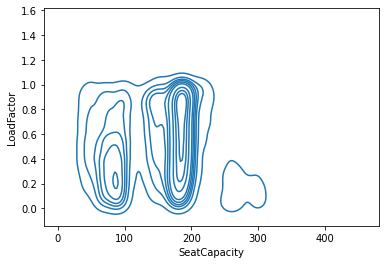

In [181]:
sns.kdeplot(x="SeatCapacity",y="LoadFactor",data=data)

/home/hinge/.virtualenvs/ai/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


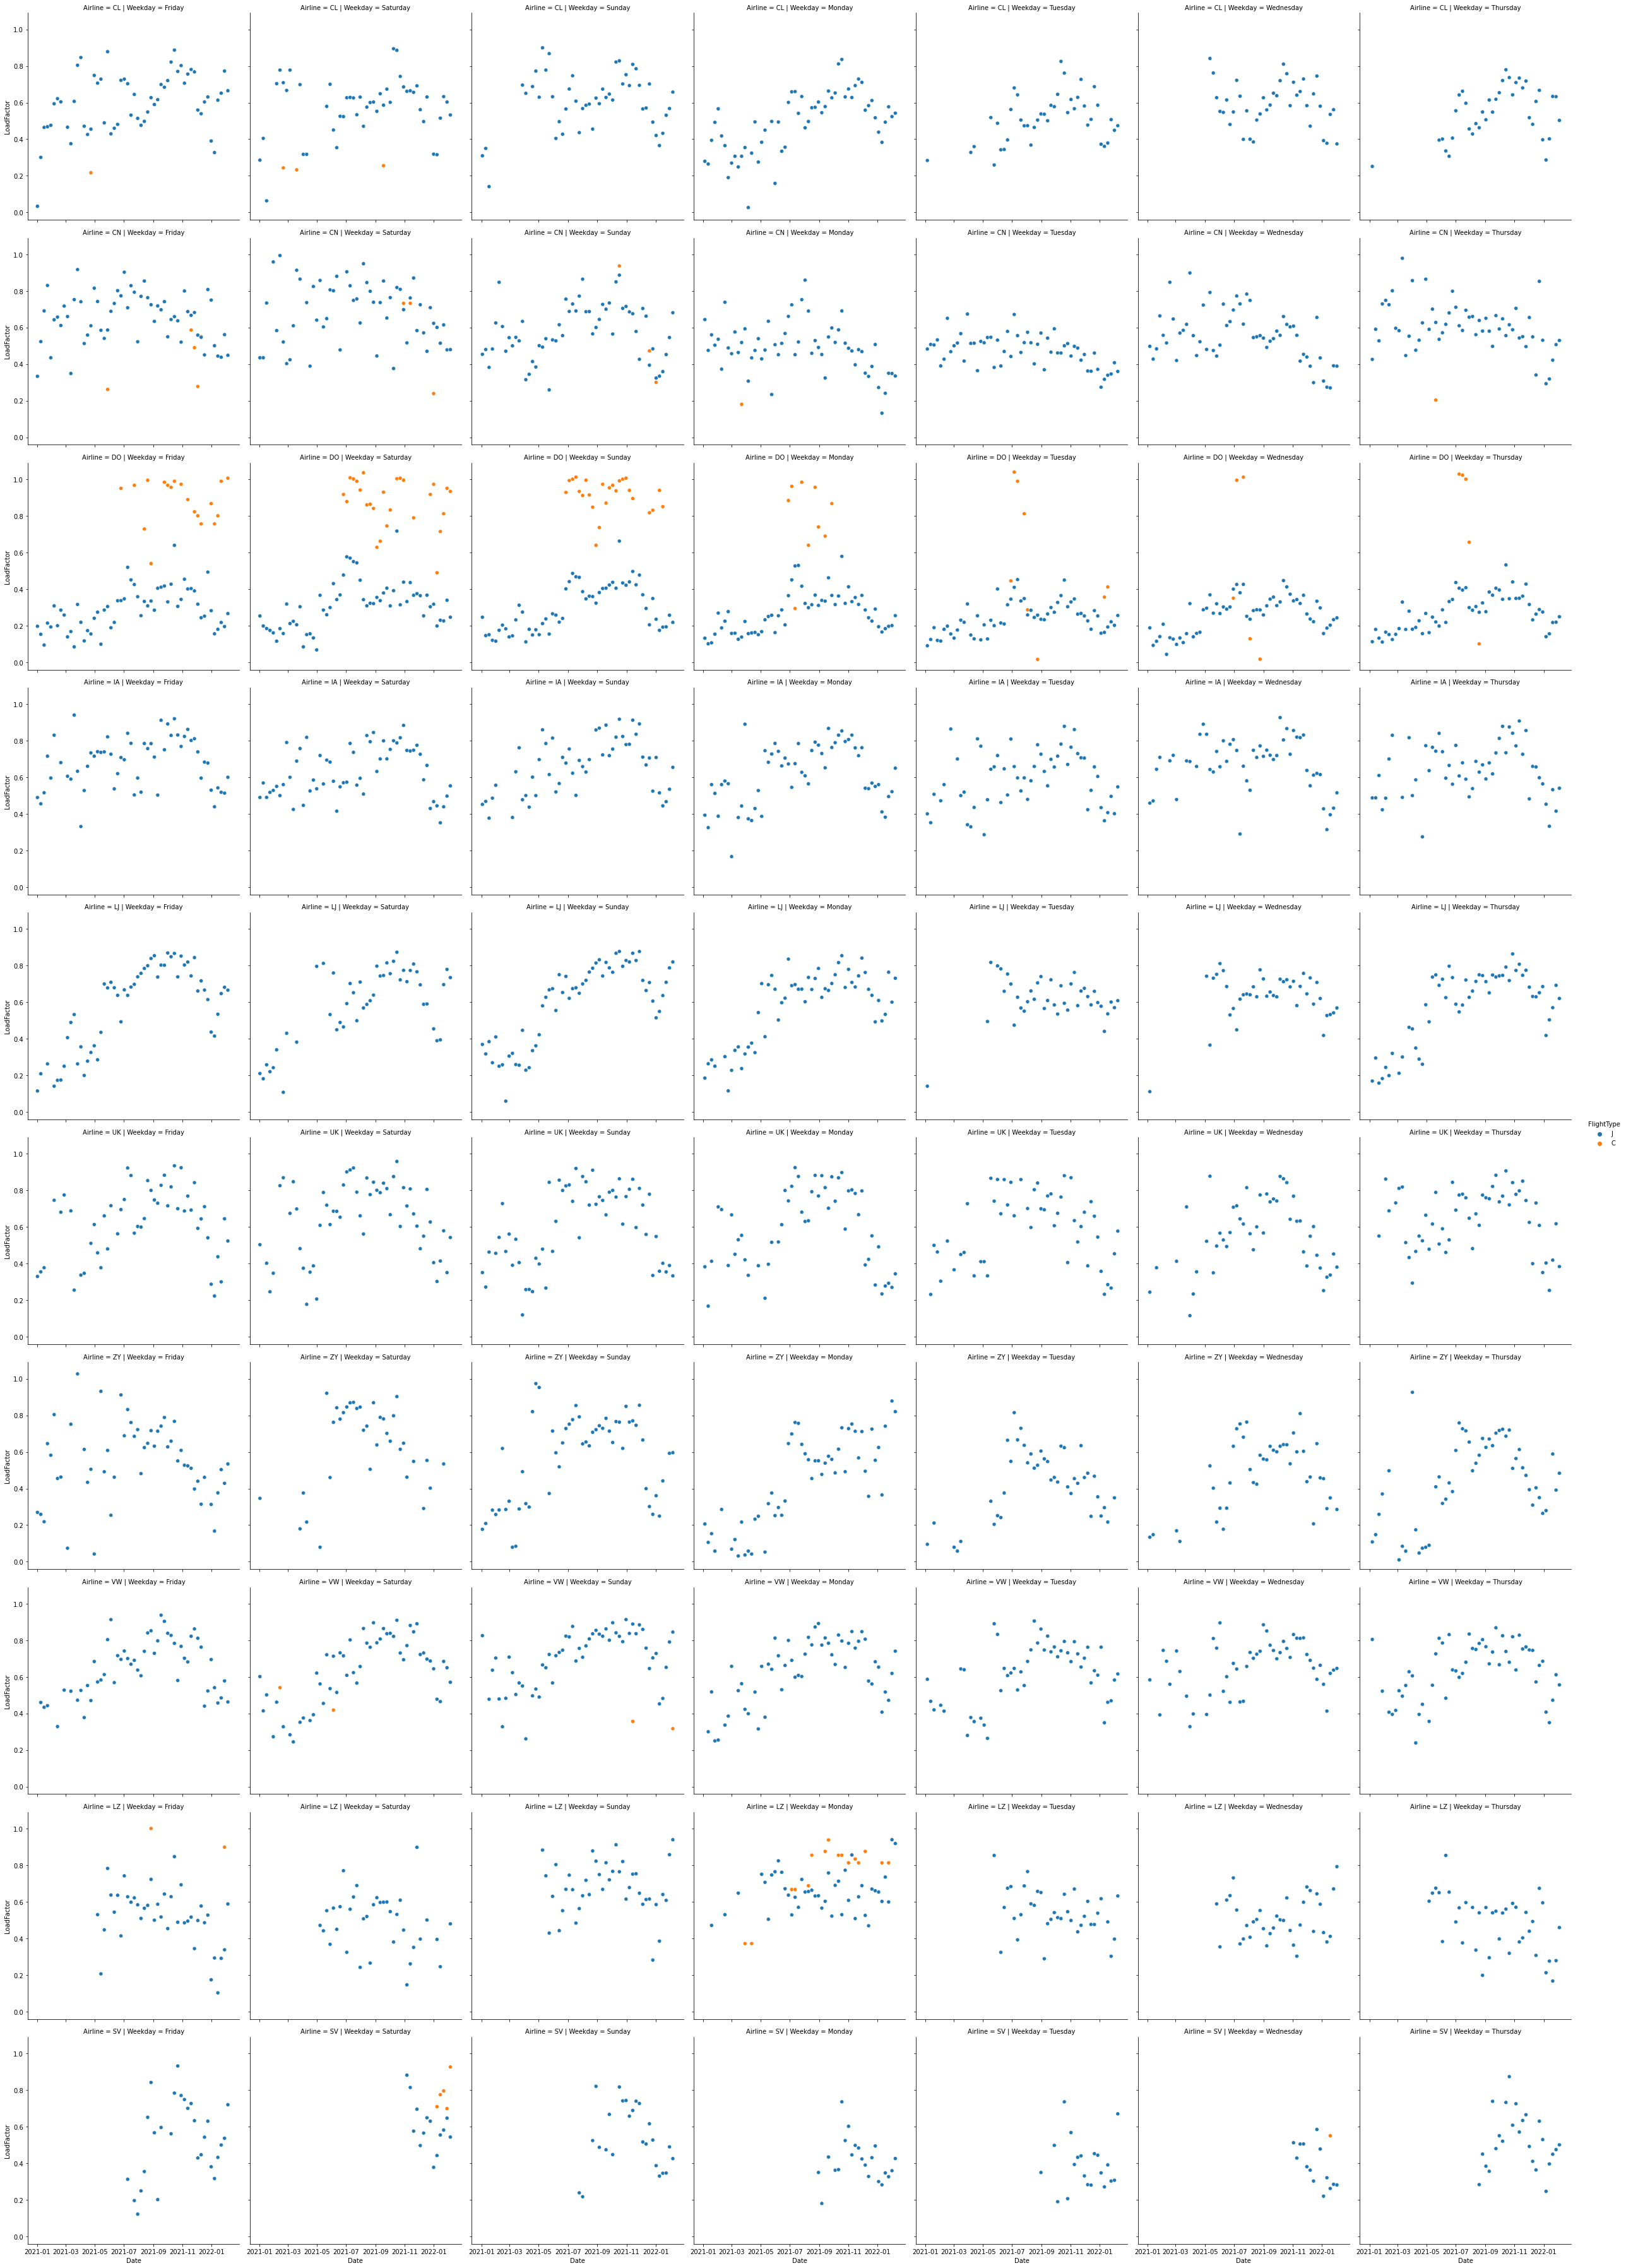

In [103]:
valid_airlines = counts.index[counts>1000]


d_ = data[data.Airline.isin(valid_airlines)].groupby(["Date","Airline","Weekday","FlightType"]).mean().reset_index()

sns.relplot("Date","LoadFactor",data=d_,row="Airline",kind="scatter",col="Weekday",hue="FlightType")

In [132]:
data.columns

Index(['ScheduleTime', 'Airline', 'FlightNumber', 'Destination',
       'AircraftType', 'FlightType', 'Sector', 'SeatCapacity', 'LoadFactor',
       'Hour', 'Date', 'Holiday', 'Weekday', 'QuarterEnd', 'MonthEnd',
       'TimeToQuarterEnd', 'TimeToMonthEnd', 'Passengers'],
      dtype='object')

In [182]:
data.FlightNumber2

AttributeError: 'DataFrame' object has no attribute 'FlightNumber2'